In [9]:
import os
import glob
import shutil
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

base_dir = '/kaggle/input/phenobench/PhenoBench/'
train_images_dir = os.path.join(base_dir, 'train', 'images')
train_annots_dir = os.path.join(base_dir, 'train', 'semantics')
val_images_dir = os.path.join(base_dir, 'val', 'images')
val_annots_dir = os.path.join(base_dir, 'val', 'semantics')

split_dir = '/kaggle/working/train_split'
train_split_dir = os.path.join(split_dir, 'train')
test_split_dir = os.path.join(split_dir, 'test')

for folder in [train_split_dir, test_split_dir]:
    os.makedirs(os.path.join(folder, 'images'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'semantics'), exist_ok=True)

print("PhenoBench: Directory paths set up successfully.")

all_train_images = sorted(glob.glob(os.path.join(train_images_dir, '*')))
filtered_train_images = []
for img_path in all_train_images:
    filename = os.path.basename(img_path)
    annot_path = os.path.join(train_annots_dir, filename)
    if os.path.exists(annot_path):
        filtered_train_images.append(img_path)
    else:
        print(f"Skipping {filename} because annotation not found.")

print(f"Total original train images: {len(all_train_images)}")
print(f"Images with semantics annotations: {len(filtered_train_images)}")

train_files, test_files = train_test_split(filtered_train_images, test_size=0.30, random_state=42)
print(f"Images in new training split: {len(train_files)}")
print(f"Images in new testing split: {len(test_files)}")

def convert_semantic_labels(mask):
    """
    Convert a semantic mask (uint16) with original labels:
      0: background, 1: crop, 2: weed, 3 & 4: partial-crop
    into a 3-class mask:
      0 -> 0 (background), 1/3/4 -> 1 (plants), 2 -> 2 (weeds).
    """
    mask = mask.astype(np.uint8)
    mask[mask == 3] = 1
    mask[mask == 4] = 1
    return mask

def copy_and_convert_files(file_list, source_img_dir, source_annot_dir, dest_img_dir, dest_annot_dir):
    """
    Copy image files and convert the corresponding annotation masks.
    """
    for img_path in file_list:
        filename = os.path.basename(img_path)
        shutil.copy(os.path.join(source_img_dir, filename), os.path.join(dest_img_dir, filename))
        annot_source = os.path.join(source_annot_dir, filename)
        if os.path.exists(annot_source):
            annot = cv2.imread(annot_source, cv2.IMREAD_UNCHANGED)
            converted_annot = convert_semantic_labels(annot)
            cv2.imwrite(os.path.join(dest_annot_dir, filename), converted_annot)
        else:
            print(f"Annotation for {filename} not found, skipping copy.")

copy_and_convert_files(train_files, train_images_dir, train_annots_dir,
                         os.path.join(train_split_dir, 'images'),
                         os.path.join(train_split_dir, 'semantics'))
copy_and_convert_files(test_files, train_images_dir, train_annots_dir,
                         os.path.join(test_split_dir, 'images'),
                         os.path.join(test_split_dir, 'semantics'))

print("PhenoBench: Files copied and semantic labels converted into 3 classes successfully.")

num_train = len(glob.glob(os.path.join(train_split_dir, 'images', '*')))
num_test = len(glob.glob(os.path.join(test_split_dir, 'images', '*')))
num_val = len(glob.glob(os.path.join(val_images_dir, '*')))
print(f"Training Split Images: {num_train}")
print(f"Testing Split Images: {num_test}")
print(f"Validation Set Images: {num_val}")


PhenoBench: Directory paths set up successfully.
Total original train images: 1407
Images with semantics annotations: 1407
Images in new training split: 984
Images in new testing split: 423
PhenoBench: Files copied and semantic labels converted into 3 classes successfully.
Training Split Images: 984
Testing Split Images: 423
Validation Set Images: 772


Displaying 10 sample images from the TRAIN split with CEI and converted semantic annotations:


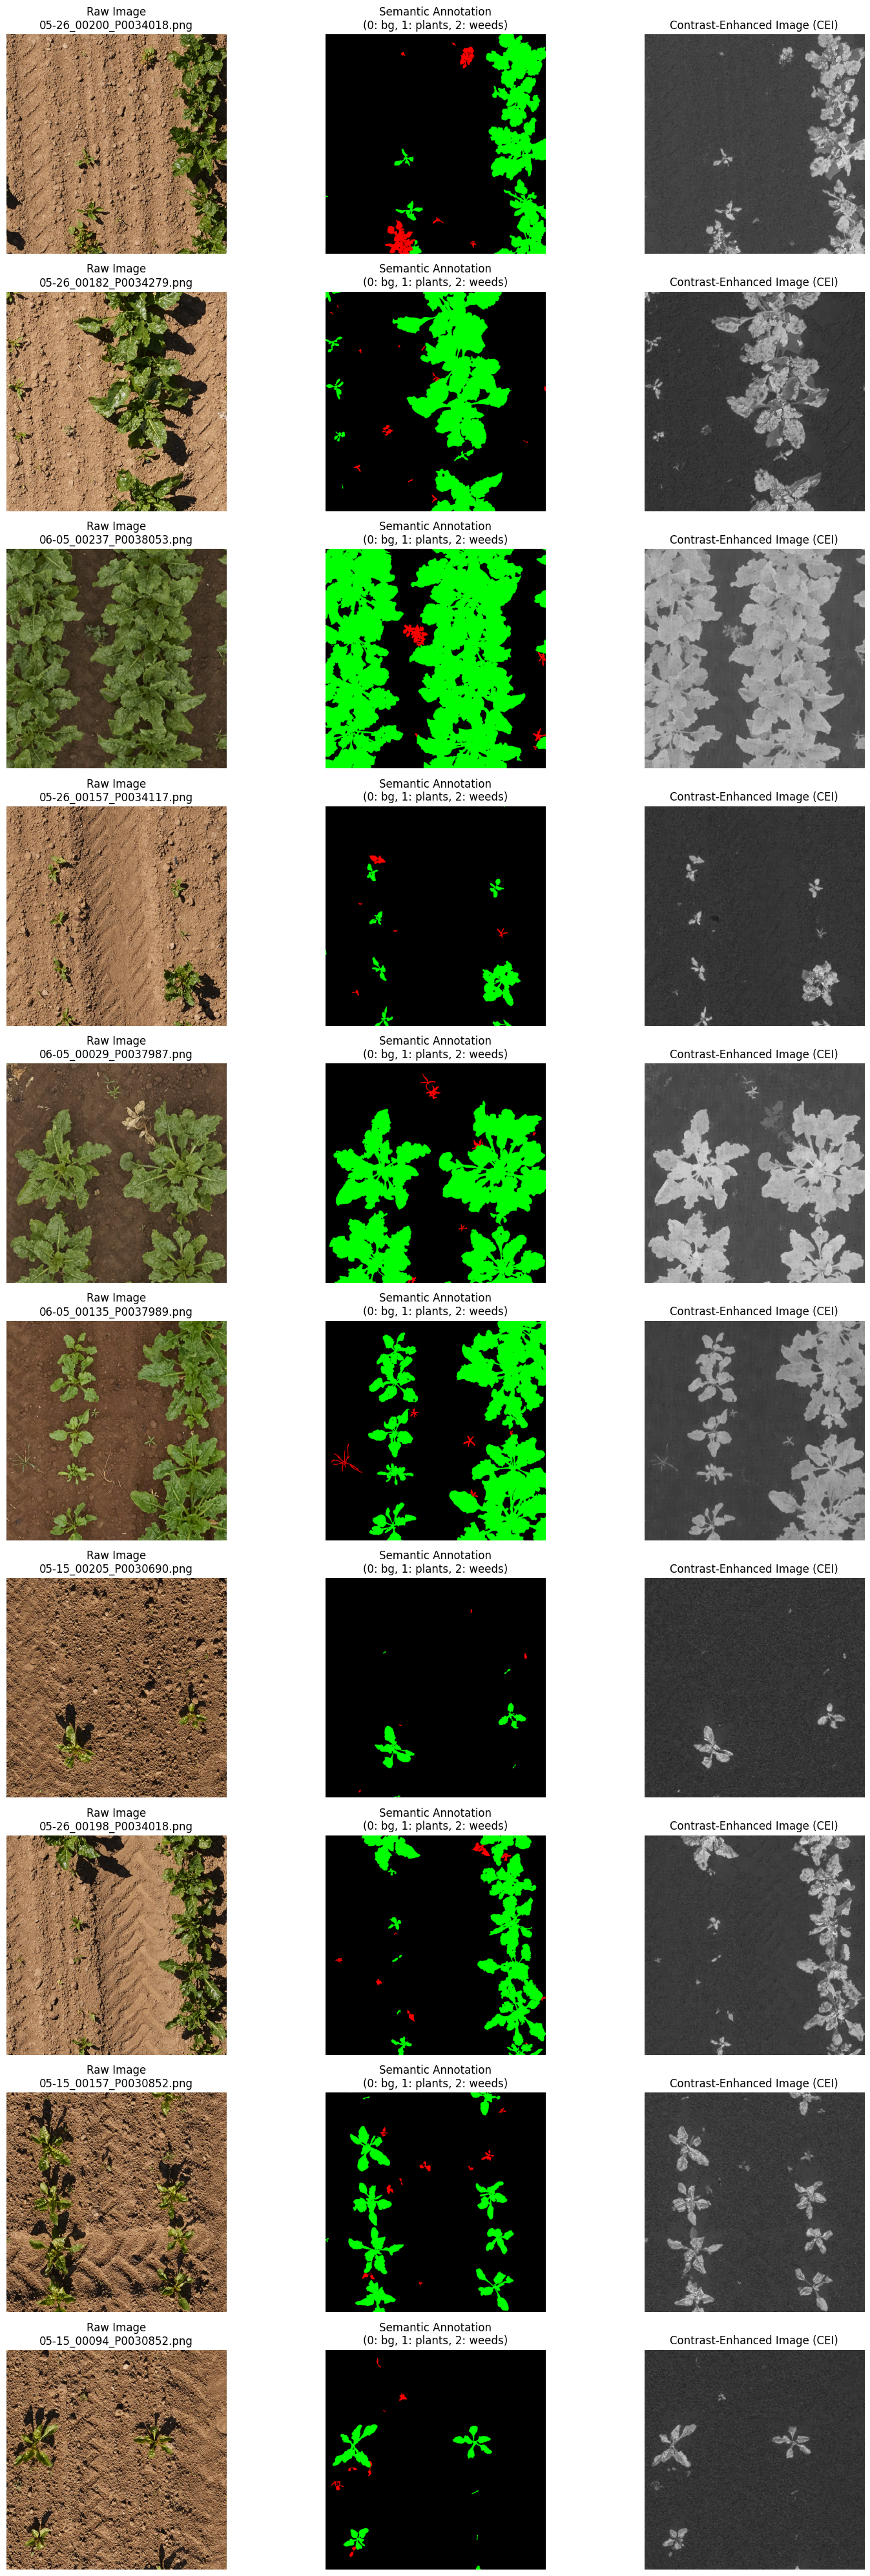

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_CEI(image):
    """
    Given a BGR image, compute a Contrast-Enhanced Image (CEI) using Excess Green (ExG):
      ExG = 2*G - R - B.
    Normalize the output to [0, 255] and return a single-channel image.
    """
    image = image.astype(np.float32)
    B, G, R = cv2.split(image)
    ExG = 2 * G - R - B  
    ExG = cv2.normalize(ExG, None, 0, 255, cv2.NORM_MINMAX)
    return ExG.astype(np.uint8)

def colorize_semantic_mask(mask):
    """
    Convert a 3-class mask into a color image:
      0: background -> black,
      1: plants    -> green,
      2: weeds     -> red.
    """
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    color_mask[mask == 0] = [0, 0, 0]
    color_mask[mask == 1] = [0, 255, 0]
    color_mask[mask == 2] = [255, 0, 0]
    return color_mask

def display_samples_with_CEI_and_semantics(split_dir, num_samples=5):
    """
    Displays a few random samples from the provided split directory.
    For each sample, it shows:
      - Raw image,
      - Colorized semantic annotation,
      - Generated CEI.
    """
    img_paths = sorted(glob.glob(os.path.join(split_dir, 'images', '*')))
    sample_indices = random.sample(range(len(img_paths)), min(num_samples, len(img_paths)))
    
    plt.figure(figsize=(16, num_samples * 4))
    for idx, i in enumerate(sample_indices):
        img_path = img_paths[i]
        annot_path = os.path.join(split_dir, 'semantics', os.path.basename(img_path))
        
        raw_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        annot_gray = cv2.imread(annot_path, cv2.IMREAD_GRAYSCALE)
        annot_color = colorize_semantic_mask(annot_gray)
        cei_img = generate_CEI(cv2.imread(img_path))
        
        plt.subplot(num_samples, 3, 3*idx + 1)
        plt.imshow(raw_img)
        plt.title(f"Raw Image\n{os.path.basename(img_path)}")
        plt.axis("off")
        
        plt.subplot(num_samples, 3, 3*idx + 2)
        plt.imshow(annot_color)
        plt.title("Semantic Annotation\n(0: bg, 1: plants, 2: weeds)")
        plt.axis("off")
        
        plt.subplot(num_samples, 3, 3*idx + 3)
        plt.imshow(cei_img, cmap="gray")
        plt.title("Contrast-Enhanced Image (CEI)")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

print("Displaying 10 sample images from the TRAIN split with CEI and converted semantic annotations:")
display_samples_with_CEI_and_semantics(train_split_dir, num_samples=10)


In [12]:
import torch
from torch.utils.data import Dataset

class PhenoBenchCEIDataset(Dataset):
    def __init__(self, split_dir, transform=None):
        """
        Args:
            split_dir (str): Directory containing 'images' and 'semantics' subfolders.
            transform (callable, optional): Optional transformations to apply.
        """
        self.images_dir = os.path.join(split_dir, 'images')
        self.semantics_dir = os.path.join(split_dir, 'semantics')
        self.image_files = sorted(glob.glob(os.path.join(self.images_dir, '*')))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        bgr_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        cei_img = generate_CEI(bgr_img)  # This produces a single-channel image.
        
        cei_img = cei_img.astype(np.float32) / 255.0
        cei_img = np.expand_dims(cei_img, axis=0)
        cei_img = torch.tensor(cei_img, dtype=torch.float)
        
        mask_path = os.path.join(self.semantics_dir, os.path.basename(img_path))
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = torch.tensor(mask, dtype=torch.long)
        
        if self.transform:
            cei_img, mask = self.transform(cei_img, mask)
            
        return cei_img, mask


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet_DO(nn.Module):
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None, norm_layer=None):
        super(ResNet_DO, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        self.groups = groups
        self.base_width = width_per_group
        # Initially set to 3 channels; this layer will be adapted later if necessary.
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.dropout1 = nn.Dropout(p=0.5)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.dropout2 = nn.Dropout(p=0.5)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.dropout3 = nn.Dropout(p=0.5)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.dropout2(x)
        x = self.layer3(x)
        x = self.dropout3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class IntermediateLayerGetter(nn.ModuleDict):
    def __init__(self, model, return_layers):
        if not set(return_layers).issubset([name for name, _ in model.named_children()]):
            raise ValueError("Return layers are not present in model")
        orig_return_layers = return_layers
        return_layers = {k: v for k, v in return_layers.items()}
        layers = OrderedDict()
        for name, module in model.named_children():
            layers[name] = module
            if name in return_layers:
                del return_layers[name]
            if not return_layers:
                break
        super(IntermediateLayerGetter, self).__init__(layers)
        self.return_layers = orig_return_layers
    def forward(self, x):
        out = OrderedDict()
        for name, module in self.items():
            x = module(x)
            if name in self.return_layers:
                out_name = self.return_layers[name]
                out[out_name] = x
        return out

class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3,
                      padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        super(ASPPConv, self).__init__(*modules)

class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        size = x.shape[-2:]
        x = super(ASPPPooling, self).forward(x)
        return F.interpolate(x, size=size, mode='bilinear', align_corners=False)

class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates):
        super(ASPP, self).__init__()
        out_channels = 256
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ))
        for rate in atrous_rates:
            modules.append(ASPPConv(in_channels, out_channels, dilation=rate))
        modules.append(ASPPPooling(in_channels, out_channels))
        self.convs = nn.ModuleList(modules)
        self.project = nn.Sequential(
            nn.Conv2d(len(modules)*out_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )
    def forward(self, x):
        res = [conv(x) for conv in self.convs]
        res = torch.cat(res, dim=1)
        return self.project(res)

class DeepLabHeadV3Plus(nn.Module):
    def __init__(self, in_channels, low_level_channels, num_classes, aspp_dilate=[12, 24, 36]):
        super(DeepLabHeadV3Plus, self).__init__()
        self.project = nn.Sequential(
            nn.Conv2d(low_level_channels, 48, kernel_size=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )
        self.aspp = ASPP(in_channels, aspp_dilate)
        self.classifier = nn.Sequential(
            nn.Conv2d(48 + 256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )
    def forward(self, features):
        low_level_feat = self.project(features['low_level'])
        aspp_feat = self.aspp(features['out'])
        aspp_feat = F.interpolate(aspp_feat, size=low_level_feat.shape[2:], mode='bilinear', align_corners=False)
        return self.classifier(torch.cat([low_level_feat, aspp_feat], dim=1))

# Overall DeepLabV3 model.
class DeepLabV3(nn.Module):
    def __init__(self, backbone, classifier):
        super(DeepLabV3, self).__init__()
        self.backbone = backbone
        self.classifier = classifier
    def forward(self, x):
        input_shape = x.shape[-2:]
        features = self.backbone(x)
        x = self.classifier(features)
        return F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)

# Builder function for DeepLabV3+ with a ResNet-50 backbone with dropout.
def deeplabv3plus_resnet50_do(num_classes=21, output_stride=8, pretrained_backbone=False):
    if output_stride == 8:
        replace_stride_with_dilation = [False, True, True]
        aspp_dilate = [12, 24, 36]
    else:
        replace_stride_with_dilation = [False, False, True]
        aspp_dilate = [6, 12, 18]
    backbone_do = ResNet_DO(Bottleneck, [3, 4, 6, 3], num_classes=1000,
                            replace_stride_with_dilation=replace_stride_with_dilation)
    return_layers = {'layer4': 'out', 'layer1': 'low_level'}
    backbone = IntermediateLayerGetter(backbone_do, return_layers=return_layers)
    classifier = DeepLabHeadV3Plus(in_channels=2048, low_level_channels=256,
                                   num_classes=num_classes, aspp_dilate=aspp_dilate)
    model = DeepLabV3(backbone, classifier)
    return model

# Example usage:
if __name__ == '__main__':
    model = deeplabv3plus_resnet50_do(num_classes=3, output_stride=8, pretrained_backbone=False)
    print("DeepLabV3+ model built successfully.")


DeepLabV3+ model built successfully.


In [15]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassCalibrationError

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

net = deeplabv3plus_resnet50_do(num_classes=3, output_stride=8, pretrained_backbone=False)
net = net.to(device)

# Replace the first convolution to accept 1 channel (for CEI input)
net.backbone.conv1 = nn.Conv2d(1, net.backbone.conv1.out_channels,
                                 kernel_size=7, stride=2, padding=3, bias=False).to(device)

# Load checkpoint and adapt the conv1 weights:
ckpt_path = '/kaggle/input/prob-dl3/pytorch/default/1/dlv3p_do_rgb_3.pth'
if os.path.exists(ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location=device)
    new_state_dict = {}
    for key, value in checkpoint.items():
        if key == 'backbone.conv1.weight':
            new_state_dict[key] = value.mean(dim=1, keepdim=True)
        else:
            new_state_dict[key] = value
    net.load_state_dict(new_state_dict)
    print("Checkpoint loaded successfully after adapting conv1 weights.")
else:
    print("Checkpoint path not found. Proceeding without pretrained weights.")

def enable_dropout(model):
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

net.eval()
enable_dropout(net)

test_dataset = PhenoBenchCEIDataset(split_dir=test_split_dir, transform=None)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, drop_last=False)

evaluator = MulticlassJaccardIndex(num_classes=3, average=None, ignore_index=-1).to(device)
mcce = MulticlassCalibrationError(num_classes=3, n_bins=3, norm='l1', ignore_index=-1).to(device)

mc_samples = 5  

with torch.no_grad():
    for idx, (images, masks) in enumerate(test_loader):
        images = images.to(device)
        masks = masks.to(device)
        
        predictions = torch.empty((0, 3, images.shape[2], images.shape[3]), device=device)
        for i in range(mc_samples):
            print(f"MC sample {i+1}/{mc_samples} for image {idx+1}")
            output = net(images)  # [B, 3, H, W]
            prob = F.softmax(output, dim=1)
            predictions = torch.cat((predictions, prob), dim=0)
        
        mean_pred = torch.mean(predictions, dim=0, keepdim=True)  # [1, 3, H, W]
        _, pred_mask = torch.max(mean_pred, dim=1)  # [1, H, W]
        
        evaluator.update(pred_mask, masks)
        mcce.update(mean_pred, masks)
        
        epsilon = 1e-8
        entropy = -torch.sum(mean_pred * torch.log(mean_pred + epsilon), dim=1)

iou_scores = evaluator.compute()
ece = mcce.compute()

print("\nOverall Evaluation Metrics on the Test Set with CEI input:")
print(f"Mean IoU: {iou_scores.mean() * 100:.2f}%")
print(f"Class-wise IoU: {iou_scores}")
print(f"Expected Calibration Error (ECE): {ece}")


Using device: cuda


/tmp/ipykernel_31/831794178.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


Checkpoint loaded successfully after adapting conv1 weights.
MC sample 1/5 for image 1
MC sample 2/5 for image 1
MC sample 3/5 for image 1
MC sample 4/5 for image 1
MC sample 5/5 for image 1
MC sample 1/5 for image 2
MC sample 2/5 for image 2
MC sample 3/5 for image 2
MC sample 4/5 for image 2
MC sample 5/5 for image 2
MC sample 1/5 for image 3
MC sample 2/5 for image 3
MC sample 3/5 for image 3
MC sample 4/5 for image 3
MC sample 5/5 for image 3
MC sample 1/5 for image 4
MC sample 2/5 for image 4
MC sample 3/5 for image 4
MC sample 4/5 for image 4
MC sample 5/5 for image 4
MC sample 1/5 for image 5
MC sample 2/5 for image 5
MC sample 3/5 for image 5
MC sample 4/5 for image 5
MC sample 5/5 for image 5
MC sample 1/5 for image 6
MC sample 2/5 for image 6
MC sample 3/5 for image 6
MC sample 4/5 for image 6
MC sample 5/5 for image 6
MC sample 1/5 for image 7
MC sample 2/5 for image 7
MC sample 3/5 for image 7
MC sample 4/5 for image 7
MC sample 5/5 for image 7
MC sample 1/5 for image 8
MC 